In [2]:
import xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from tqdm import tqdm
from preprocess.sza import solarzenithangle
from utils.etc import benchmark
from dask.distributed import Client
import shutil, gc
import os

In [3]:
client = Client(n_workers=12)

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42807 instead
  warnings.warn(


In [4]:
stations = xarray.open_dataset('/scratch/snx3000/kschuurm/DATA/DWD/netcdf/DWD_SOLAR_index.nc')
stations.station_id.values

array([ 3287,   891,  3231,  3023,  3631,  1691,  2261,  3946,  5792,
         963,  5516,  4336,  1612,  3987,  3015,  4911,   701,  5839,
        2485,   232,  4745,  1757,  1078,  1957,   722,   282, 15444,
        3126,   867,  7351,   656,  3513,  1684,  5142,  6163,  4928,
        7369,  4466,  2638,  2483,  3158,  2290,  5404,   222,  3196,
         853,  3032,  1580,  4347,  2925,  1605,  3366,  1766,  7370,
        2044,  7368, 15000,  1270,  5906,  2014,  5009,  5779,  2522,
         953,  3761,  5397,  2667,  4104,  1001,  2171,   430,   460,
         183,  3660,   554,   596,  1503,  1346,  5100,   662,  4177,
        5705,  1443,  7374,  5467,  3668,  1468,  6197,  2559,  7244,
         198,  1420, 13674,  1544,  3086,  2115,  5426,  5629,  5155,
         342,  4024,  1358,  4642,  1550,  3098,   880,  4887,   591,
        5490,  7367,  2907,  1869,  3268,  1639,   427,   856,  3028,
        5546,  2601,   704,  1975,  1048,  2932,   840,  3167,   164,
        5440,   298,

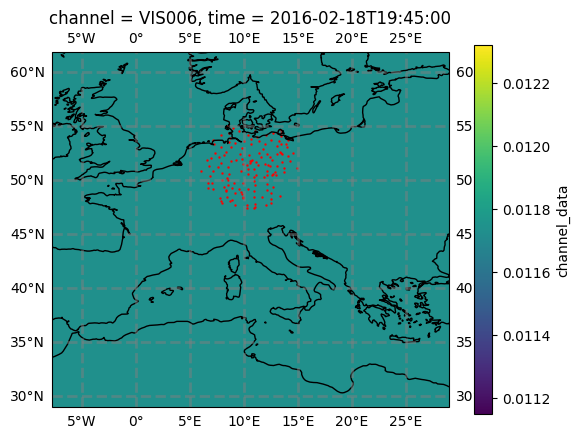

In [5]:
hrseviri = xarray.open_zarr('/scratch/snx3000/kschuurm/ZARR/SEVIRI_new.zarr')

proj = ccrs.PlateCarree()

fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=proj))

gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

axis.coastlines()

lat = stations.lat.values
lon = stations.lon.values
name = stations.name.values
axis.scatter(x=lon, y=lat, c='r', s=.5)
# for i, txt in enumerate(name):
#     axis.annotate(txt, (lon[i], lat[i]))

hrseviri.channel_data.sel(channel='VIS006').isel(time = 2000).plot.imshow(ax=axis, transform = proj)



In [6]:


def create_collocated_zarr_dwd(hrseviri, station_id, patch_size=31):
    
    station = xarray.open_dataset(f'/scratch/snx3000/kschuurm/DATA/DWD/netcdf/DWD_SOLAR_10min_{str(station_id).zfill(5)}.nc')

    lat = station.lat.values
    lon = station.lon.values
    ilat = (np.abs(hrseviri.y - lat)).argmin().values
    ilon = (np.abs(hrseviri.x - lon)).argmin().values

    hpatch = int(np.floor(patch_size/2))

    station['time'] = station.time - np.timedelta64(10, 'm')

    intersec = set(station.time.values).intersection(hrseviri.time.values)

    if len(intersec)< 1000:
        print(f'skipping station, too little points {station_id}')
        return None

    
    with benchmark('load'):
        hres_slice = hrseviri.isel(y=slice(ilat-hpatch, ilat + hpatch +1), x=slice(ilon-hpatch, ilon+hpatch+1)).load()
    for v in list(hres_slice.coords.keys()):
        if hres_slice.coords[v].dtype == object:
            hres_slice[v].encoding.clear()
    for var in hres_slice:
        hres_slice[var].encoding.clear()

    # with benchmark('temp2'):
    #     hres_slice.chunk({'time':10000, 'x':-1, 'y':-1}).to_zarr('temp2.zarr', mode='w')
    #     temp = xarray.open_zarr('temp2.zarr')
    

    intersec_time = np.unique(np.array(list(set(station.time.values).intersection(set(hres_slice.time.values)))))
    if len(intersec_time)<50:
        print(f'skipping {station_id} to little matching timeindices')
        return None
    subset_station = station.sel(time=intersec_time)
    hres_slice = hres_slice.sel(time=intersec_time)

    hres_slice['GHI'] = ('time', (subset_station.GS_10.data/(10*60))*10000)# J/cm2 per 10 min to watt/m2
    
    hres_slice['DIF'] = ('time', (subset_station.DS_10.data/(10*60))*10000)
    hres_slice['station_name'] = str(subset_station.station_name.values)
    hres_slice['lat_station'] = subset_station.lat.data
    hres_slice['lon_station'] = subset_station.lon.data
    hres_slice['altitude_station'] = subset_station.elevation.data
    
    with benchmark('dropna'):
        hres_slice = hres_slice.dropna('time')

    with benchmark('SZA'):
        SZA, AZI = solarzenithangle(pd.to_datetime(hres_slice.time), 
                                    hres_slice.lat_station.values, 
                                    hres_slice.lon_station.values, 
                                    hres_slice.altitude_station.values)

    hres_slice['SZA'] = ('time', SZA.astype(np.float32))
    hres_slice['AZI'] = ('time', AZI.astype(np.float32))

    for v in list(hres_slice.coords.keys()):
        if hres_slice.coords[v].dtype == object:
            hres_slice[v].encoding.clear()

    hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
    hres_slice = hres_slice.chunk({'time':10000, 'channel':-1, 'lat':-1, 'lon':-1})

    with benchmark('zarr'):
        hres_slice.to_zarr(SAVE_PATH + f'DWD_SOLAR_{str(station_id).zfill(5)}.zarr', mode='w')
    
    print(f'        STATION {station_id} DONE         ')

def create_collocated_zarr_knmi(hrseviri, station_id, patch_size=31):
    station = xarray.open_dataset(f'/scratch/snx3000/kschuurm/DATA/KNMI/nc/KNMI_SOLAR_10min_{str(station_id)}.nc')
    
    lat = station.lat.values
    lon = station.lon.values
    ilat = (np.abs(hrseviri.y - lat)).argmin().values
    ilon = (np.abs(hrseviri.x - lon)).argmin().values

    hpatch = int(np.floor(patch_size/2))

    station['time'] = station.time - np.timedelta64(10, 'm')
    
    intersec = set(station.time.values).intersection(hrseviri.time.values)

    if len(intersec)< 1000:
        print(f'skipping station, too little points {station_id}')
        return None


    hres_slice = hrseviri.isel(y=slice(ilat-hpatch, ilat + hpatch +1), x=slice(ilon-hpatch, ilon+hpatch+1)).load()
    for v in list(hres_slice.coords.keys()):
        if hres_slice.coords[v].dtype == object:
            hres_slice[v].encoding.clear()
    for var in hres_slice:
        hres_slice[var].encoding.clear()

    # with benchmark('temp2'):
    #     hres_slice.chunk({'time':10000, 'x':-1, 'y':-1}).to_zarr('temp2.zarr', mode='w')
    #     temp = xarray.open_zarr('temp2.zarr')
        
    intersec_time = np.sort(np.array(list(set(station.time.values).intersection(set(hres_slice.time.values)))))
    if len(intersec_time)<50:
        print(f'skipping {station_id} to little matching timeindices')
        return None
    subset_station = station.sel(time=intersec_time)
    hres_slice = hres_slice.sel(time=intersec_time)
    
    hres_slice['GHI'] = ('time', subset_station.Q_GLOB_10.data)
    hres_slice['GHI_min'] = ('time', subset_station.QN_GLOB_10.data)
    hres_slice['GHI_max'] = ('time', subset_station.QX_GLOB_10.data)
    hres_slice['station_name'] = str(station_id)
    hres_slice['lat_station'] = subset_station.lat.data
    hres_slice['lon_station'] = subset_station.lon.data
    hres_slice['altitude_station'] = subset_station.altitude.data
    
    with benchmark('dropna'):
        hres_slice = hres_slice.dropna('time')
    
    with benchmark('SZA'):
        SZA, AZI = solarzenithangle(pd.to_datetime(hres_slice.time), 
                                    hres_slice.lat_station.values, 
                                    hres_slice.lon_station.values, 
                                    hres_slice.altitude_station.values)

    hres_slice['SZA'] = ('time', SZA.astype(np.float32))
    hres_slice['AZI'] = ('time', AZI.astype(np.float32))

    for v in list(hres_slice.coords.keys()):
        if hres_slice.coords[v].dtype == object:
            hres_slice[v].encoding.clear()

    hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
    hres_slice = hres_slice.chunk({'time':10000, 'channel':-1, 'lat':-1, 'lon':-1})

    with benchmark('zarr'):
        hres_slice.to_zarr(SAVE_PATH + f'KNMI_SOLAR_{str(station_id)}.zarr', mode='w')
    
    print(f'        STATION {station_id} DONE         ')
    
    
import shutil
import gc

def rechunk_zarr_store(zarr, chunks, target_zarr):
    slice_lengths = int(len(zarr.time) / 250)
    temp = xarray.open_zarr(target_zarr)
    already_rechunked = len(temp.time)
    temp.close()
    
    # already_rechunked =0
    for i in tqdm(range(0, len(zarr.time), slice_lengths)):
        if i + slice_lengths <= already_rechunked:
            print(f'skipped {i}')
            continue

        if i < already_rechunked and i + slice_lengths > already_rechunked:
            zarr_slice = zarr.isel(time=slice(already_rechunked, i+slice_lengths))
        else:
            zarr_slice = zarr.isel(time=slice(i, i + slice_lengths))
        
        for v in list(zarr_slice.coords.keys()):
            if zarr_slice.coords[v].dtype == object:
                zarr_slice[v].encoding.clear()
                
        for var in zarr_slice:
            zarr_slice[var].encoding.clear()
        

        zarr_slice = zarr_slice.chunk(chunks)
            
        if i == 0:
            zarr_slice.to_zarr(target_zarr, mode="w")
        else:
            zarr_slice.to_zarr(target_zarr, append_dim="time")
        del zarr_slice
        gc.collect()

In [7]:
# rechunk_zarr_store(hrseviri, {'time':10000, 'x':50, 'y':50}, 'temp_SEVIRI.zarr')

In [ ]:

SAVE_PATH = f'/scratch/snx3000/kschuurm/ZARR/DWD/'
stations_dwd = xarray.open_dataset('/scratch/snx3000/kschuurm/DATA/DWD/netcdf/DWD_SOLAR_index.nc')


hrseviri = xarray.open_zarr('temp_SEVIRI.zarr')

for nm in tqdm(stations_dwd.station_id.values):
    if os.path.exists(SAVE_PATH + f'DWD_SOLAR_{str(nm).zfill(5)}.zarr'):
        print(f'skip {nm}')
        continue
    try:
        create_collocated_zarr_dwd(hrseviri, nm)
    except Exception as e:
        print(e)



In [ ]:
SAVE_PATH = f'/scratch/snx3000/kschuurm/ZARR/KNMI/'

stations_knmi = xarray.open_dataset('/scratch/snx3000/kschuurm/DATA/KNMI/nc/index.nc')

try:
    # rechunk_zarr_store(hrseviri, {'time':10000, 'x':50, 'y':50}, 'temp.zarr')
    # rechunk_zarr_store(xarray.open_zarr('temp.zarr'), {'time':5000}, 'temp2.zarr')
    
    hrseviri = xarray.open_zarr('temp_SEVIRI.zarr')
    
    for nm in tqdm(stations_knmi.station.values):
        # if os.path.exists(SAVE_PATH + f'KNMI_SOLAR_{str(nm)}.zarr'):
        #     print(f'skip {nm}')
        #     continue
        if os.path.exists(f'/scratch/snx3000/kschuurm/DATA/KNMI/nc/KNMI_SOLAR_10min_{str(nm)}.nc'):
            create_collocated_zarr_knmi(hrseviri, nm)
        else:
            print('station does not have data')
      
except Exception as e:
    print(e)
    raise e

  0%|          | 0/40 [00:00<?, ?it/s]

station does not have data
station does not have data
dropna : 5.608 seconds
SZA : 2.636 seconds


/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.59 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
  8%|▊         | 3/40 [00:53<11:04, 17.97s/it]

zarr : 14.521 seconds
        STATION 240_S_18Ct DONE         
dropna : 3.356 seconds
SZA : 1.431 seconds


/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.99 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 10%|█         | 4/40 [01:30<14:18, 23.85s/it]

zarr : 9.515 seconds
        STATION 240_S_ISAD DONE         
dropna : 3.331 seconds
SZA : 1.668 seconds


/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.97 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 12%|█▎        | 5/40 [02:05<16:05, 27.59s/it]

zarr : 9.354 seconds
        STATION 240_S_ISMU DONE         
dropna : 3.284 seconds
SZA : 1.662 seconds


/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.98 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 15%|█▌        | 6/40 [02:42<17:10, 30.31s/it]

zarr : 10.234 seconds
        STATION 240_S_ISNK DONE         
dropna : 2.778 seconds
SZA : 0.001 seconds


/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 18%|█▊        | 7/40 [03:05<15:29, 28.17s/it]

zarr : 0.314 seconds
        STATION 240_S_ISNV DONE         
dropna : 5.593 seconds
SZA : 3.927 seconds


/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.59 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 8/40 [04:02<19:41, 36.91s/it]

zarr : 15.835 seconds
        STATION 249_S_a DONE         
dropna : 5.496 seconds
SZA : 2.570 seconds


/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.59 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▎       | 9/40 [04:59<22:10, 42.93s/it]

zarr : 14.478 seconds
        STATION 251_S_a DONE         
dropna : 5.493 seconds
SZA : 2.563 seconds


/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.59 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 25%|██▌       | 10/40 [05:51<22:52, 45.75s/it]

zarr : 14.299 seconds
        STATION 257_S_a DONE         
dropna : 5.395 seconds
SZA : 2.292 seconds


/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.59 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 28%|██▊       | 11/40 [06:45<23:23, 48.39s/it]

zarr : 14.127 seconds
        STATION 260_S_a DONE         
dropna : 5.873 seconds
SZA : 3.257 seconds


/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.58 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


zarr : 14.746 seconds
        STATION 261_S_a DONE         


 30%|███       | 12/40 [07:42<23:46, 50.96s/it]

dropna : 5.469 seconds
SZA : 2.551 seconds


/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.59 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 32%|███▎      | 13/40 [08:36<23:18, 51.79s/it]

zarr : 14.939 seconds
        STATION 267_S_a DONE         
dropna : 5.491 seconds
SZA : 2.545 seconds


/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.59 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▌      | 14/40 [09:26<22:16, 51.41s/it]

zarr : 15.120 seconds
        STATION 269_S_23t DONE         
dropna : 5.426 seconds
SZA : 2.556 seconds


/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_24618/3827708520.py:134: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.59 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 38%|███▊      | 15/40 [10:18<21:23, 51.35s/it]

zarr : 14.566 seconds
        STATION 270_S_a DONE         


# PLAYGROUND


In [33]:
stations_id = stations.station_id[0].values
station = xarray.open_dataset(f'/scratch/snx3000/kschuurm/DATA/DWD/netcdf/DWD_SOLAR_10min_{str(stations_id).zfill(5)}.nc')

lat = station.lat.values
lon = station.lon.values
ilat = (np.abs(hrseviri.y - lat)).argmin().values
ilon = (np.abs(hrseviri.x - lon)).argmin().values

patch_size = 31
hpatch = int(np.floor(patch_size/2))

station['time'] = station.time - np.timedelta64(10, 'm')

intersec = set(station.time.values).intersection(hrseviri.time.values)

if len(intersec)< 1000:
    print('skipping station')


hres_slice = hrseviri.isel(y=slice(ilat-hpatch, ilat + hpatch +1), x=slice(ilon-hpatch, ilon+hpatch+1))
for v in list(hres_slice.coords.keys()):
    if hres_slice.coords[v].dtype == object:
        hres_slice[v].encoding.clear()
for var in hres_slice:
    hres_slice[var].encoding.clear()

with benchmark('temp'):
    hres_slice.chunk({'time':10000}).to_zarr('temp.zarr', mode='w')
    temp = xarray.open_zarr('temp.zarr')
    
timeindexnotnan = np.load('/scratch/snx3000/kschuurm/ZARR/idxnotnan_seviri.npy')
intersec_time = set(station.time.values).intersection(set(timeindexnotnan))
if len(intersec_time) < 100:
    print(station.time.values)
    print(intersec_time)
    print(f'skipping station {station_id}, too little collocated points')
    
intersec_time = np.sort(np.array(list(intersec_time)))
hres_slice = temp.sel(time=intersec_time)
subset_station = station.sel(time=intersec_time)
subset_station = station.sel(time=hres_slice.time)
hres_slice['GHI'] = ('time', subset_station.GS_10.data/(10*60))# J/cm2 per 10 min to W/m2
hres_slice['DIF'] = ('time', subset_station.DS_10.data/(10*60))
hres_slice['station_name'] = str(subset_station.station_name.values)
hres_slice['lat_station'] = subset_station.lat.data
hres_slice['lon_station'] = subset_station.lon.data
hres_slice['altitude_station'] = subset_station.elevation.data

with benchmark('SZA'):
    SZA, AZI = solarzenithangle(pd.to_datetime(hres_slice.time), 
                                hres_slice.lat_station.values, 
                                hres_slice.lon_station.values, 
                                hres_slice.altitude_station.values)

hres_slice['SZA'] = ('time', SZA.astype(np.float32))
hres_slice['AZI'] = ('time', AZI.astype(np.float32))

for v in list(hres_slice.coords.keys()):
    if hres_slice.coords[v].dtype == object:
        hres_slice[v].encoding.clear()

hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
hres_slice = hres_slice.chunk({'time':10000, 'channel':-1, 'lat':-1, 'lon':-1})

with benchmark('zarr'):
    hres_slice.to_zarr('temp2.zarr', mode='w')


temp : 7.209 seconds


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



SZA : 2.617 seconds


/tmp/ipykernel_1216/3243476360.py:63: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_1216/3243476360.py:63: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})


zarr : 3.978 seconds


In [42]:
hres_slice.channel_data.isnull().any(axis=(1, 2,3)).values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [10]:
stations_knmi = xarray.open_dataset('/scratch/snx3000/kschuurm/DATA/KNMI/nc/index.nc')
stations_knmi

<xarray.Dataset>
Dimensions:     (station: 40)
Coordinates:
  * station     (station) <U10 '215_S_a' '235_S_obs' ... '873_S_a' '990_S_a'
Data variables:
    name        (station) <U29 ...
    lat         (station) float64 ...
    lon         (station) float64 ...
    altitude    (station) float64 ...
    date_start  (station) datetime64[ns] ...
    date_end    (station) datetime64[ns] ...

In [23]:
station_id = stations_knmi.station[5].values
station = xarray.open_dataset(f'/scratch/snx3000/kschuurm/DATA/KNMI/nc/KNMI_SOLAR_10min_{str(station_id)}.nc')
station

<xarray.Dataset>
Dimensions:     (time: 282528)
Coordinates:
  * time        (time) datetime64[ns] 2022-07-01T00:10:00 ... 2019-05-01
    lat         float64 ...
    lon         float64 ...
    altitude    float64 ...
Data variables:
    Q_GLOB_10   (time) float32 ...
    QN_GLOB_10  (time) float32 ...
    QX_GLOB_10  (time) float32 ...
    SQ_10       (time) timedelta64[ns] ...
Attributes:
    provider:    KNMI
    station:     240_S_ISNK
    name:        Schiphol locatie Nieuwkoop
    start_date:  2018-10-17T00:10:00
    end_date:    2024-03-01T00:00:00

In [28]:

station = xarray.open_dataset(f'/scratch/snx3000/kschuurm/DATA/KNMI/nc/KNMI_SOLAR_10min_{str(station_id)}.nc')

lat = station.lat.values
lon = station.lon.values
ilat = (np.abs(hrseviri.y - lat)).argmin().values
ilon = (np.abs(hrseviri.x - lon)).argmin().values

patch_size = 31
hpatch = int(np.floor(patch_size/2))

station['time'] = station.time - np.timedelta64(10, 'm')

intersec = set(station.time.values).intersection(hrseviri.time.values)

if len(intersec)< 1000:
    print('skipping station')


hres_slice = hrseviri.isel(y=slice(ilat-hpatch, ilat + hpatch +1), x=slice(ilon-hpatch, ilon+hpatch+1))
for v in list(hres_slice.coords.keys()):
    if hres_slice.coords[v].dtype == object:
        hres_slice[v].encoding.clear()
for var in hres_slice:
    hres_slice[var].encoding.clear()

with benchmark('temp'):
    hres_slice.chunk({'time':10000, 'x':-1, 'y':-1}).to_zarr('temp2.zarr', mode='w')
    temp = xarray.open_zarr('temp2.zarr')
    
hres_slice = temp.where(temp.time.isin(station.time), drop=True)
_, index = np.unique(hres_slice['time'], return_index=True)
subset_station = station.isel(time=index)

hres_slice['GHI'] = ('time', subset_station.Q_GLOB_10.data)
hres_slice['GHI_min'] = ('time', subset_station.QN_GLOB_10.data)
hres_slice['GHI_max'] = ('time', subset_station.QX_GLOB_10.data)
hres_slice['station_name'] = str(station_id)
hres_slice['lat_station'] = subset_station.lat.data
hres_slice['lon_station'] = subset_station.lon.data
hres_slice['altitude_station'] = subset_station.altitude.data

with benchmark('SZA'):
    SZA, AZI = solarzenithangle(pd.to_datetime(hres_slice.time), 
                                hres_slice.lat_station.values, 
                                hres_slice.lon_station.values, 
                                hres_slice.altitude_station.values)

hres_slice['SZA'] = ('time', SZA.astype(np.float32))
hres_slice['AZI'] = ('time', AZI.astype(np.float32))

for v in list(hres_slice.coords.keys()):
    if hres_slice.coords[v].dtype == object:
        hres_slice[v].encoding.clear()

hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})


hres_slice

temp : 14.553 seconds
SZA : 2.003 seconds


/tmp/ipykernel_32736/709354745.py:55: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_32736/709354745.py:55: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})


<xarray.Dataset>
Dimensions:           (channel: 11, time: 66939, lat: 31, lon: 31)
Coordinates:
  * channel           (channel) object 'IR_016' 'IR_039' ... 'WV_062' 'WV_073'
  * time              (time) datetime64[ns] 2018-10-17 ... 2022-12-31T23:30:00
  * lon               (lon) float64 4.025 4.075 4.125 ... 5.425 5.475 5.525
  * lat               (lat) float64 51.58 51.62 51.68 ... 52.98 53.03 53.08
Data variables:
    channel_data      (channel, time, lat, lon) float16 dask.array<chunksize=(11, 1140, 31, 31), meta=np.ndarray>
    GHI               (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    GHI_min           (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    GHI_max           (time) float32 0.0 0.0 1.0 1.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    station_name      <U10 '240_S_ISNK'
    lat_station       float64 52.32
    lon_station       float64 4.79
    altitude_station  float64 -3.3
    SZA               (time) float32 2.379 2.355 2.318 2.27 ... 2.574 2.61 2.629
    AZI               (time) float32 0.2109 0.3927 0.5647 ... 5.709 5.929 6.168

In [9]:
timeidxnotnan_seviri = np.load('/scratch/snx3000/kschuurm/ZARR/idxnotnan_seviri.npy')
timeidxnotnan_seviri


array(['2016-01-01T00:00:00.000000000', '2016-01-01T00:15:00.000000000',
       '2016-01-01T00:30:00.000000000', ...,
       '2022-12-31T23:15:00.000000000', '2022-12-31T23:30:00.000000000',
       '2022-12-31T23:45:00.000000000'], dtype='datetime64[ns]')

In [8]:
len(hrseviri.time) - len(timeidxnotnan_seviri)

60386